# API de OpenWeatherMap para data histórica de contaminación del aire

## Parámetros de la API:

* `lat`: Latitud de la ciudad.

* `lon`: Longitud de la ciudad.

* `start`: Fecha de inicio en tiempo Unix (zona horaria UTC).

* `end`: Fecha de fin en tiempo Unix (zona horaria UTC).

* `appid`: Clave única, que puedes encontrar en la página de tu cuenta denominada `API key`.

In [1]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importar librerias
import pandas as pd
import requests
import time
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta
from sqlalchemy import create_engine

In [3]:
# Importar las funciones desde functions.py
from functions import api_key_from_file, extract_data_from_api, transform_data, pwd_from_file, load_data_to_redshift

In [4]:
# Cargamos las variables de entorno desde el archivo .env
load_dotenv()

# Accedemos a las variables de entorno
api_key = os.getenv('api_key')
pwd_redshift = os.getenv('pwd_redshift')

# Verificamos que las variables se han cargado correctamente
if api_key and pwd_redshift:
    print("Las variables de entorno se han cargado correctamente.")
else:
    print("Error al cargar las variables de entorno.")

Las variables de entorno se han cargado correctamente.


In [5]:
# Definir los parámetros necesarios
api_key = api_key
lat = "-37.2075"
lon = "-73.2368"
end_date = datetime.now()
start_date = end_date - timedelta(days=36*30)

## Campos en la respuesta de la API:

* `coord`: Coordenadas de la ubicación especificada (latitud, longitud).

* `dt`: Fecha y hora en formato Unix (UTC).

* `main.aqi`: Índice de Calidad del Aire (Air Quality Index). Valores posibles:
  - 1 = Bueno
  - 2 = Aceptable
  - 3 = Moderado
  - 4 = Malo
  - 5 = Muy malo

* `components.co`: Concentración de CO (Monóxido de Carbono), μg/m³.
* `components.no`: Concentración de NO (Monóxido de Nitrógeno), μg/m³.
* `components.no2`: Concentración de NO2 (Dióxido de Nitrógeno), μg/m³.
* `components.o3`: Concentración de O3 (Ozono), μg/m³.
* `components.so2`: Concentración de SO2 (Dióxido de Azufre), μg/m³.
* `components.pm2_5`: Concentración de PM2.5 (Partículas Finas), μg/m³.
* `components.pm10`: Concentración de PM10 (Partículas Gruesas), μg/m³.
* `components.nh3`: Concentración de NH3 (Amoníaco), μg/m³.

## Extracción de los datos 

In [6]:
# Extraer datos de la API
raw_data = extract_data_from_api(api_key, lat, lon, start_date, end_date)

# Verifica el número de registros o las claves del diccionario
print(f"Número de registros extraídos: {len(raw_data)}")
print(f"Claves disponibles: {list(raw_data.keys())}")

Número de registros extraídos: 2
Claves disponibles: ['coord', 'list']


## Transformación de los Datos

In [7]:
# Transformar los datos
df = transform_data(raw_data)

df

,date,aqi,co,no,no2,o3,so2,pm_2_5,pm_10,nh3
0,2021-08-30,1,333.79,0.00,4.28,42.92,0.45,4.25,8.16,0.90
1,2021-08-31,1,297.07,0.00,2.72,49.35,0.54,3.13,6.13,0.70
2,2021-08-31,1,293.73,0.00,2.23,50.78,0.68,3.01,5.78,0.65
3,2021-08-31,1,290.39,0.00,1.99,50.78,1.16,3.25,5.57,0.59
4,2021-08-31,1,287.06,0.00,2.04,48.64,2.18,3.94,6.12,0.56
...,...,...,...,...,...,...,...,...,...,...
25603,2024-08-14,1,236.99,0.01,0.75,57.94,0.04,0.50,0.76,0.18
25604,2024-08-14,1,240.33,0.00,1.00,54.36,0.06,0.56,0.93,0.22
25605,2024-08-14,1,243.66,0.00,1.14,51.50,0.07,0.70,1.19,0.23
25606,2024-08-14,1,247.00,0.00,1.15,49.35,0.08,0.79,1.36,0.24


## Checkeo preliminar de valores duplicados y nulos

In [8]:
# Verificar existencia de datos duplicados
df.duplicated().sum()

0

In [9]:
# Verificar existencia de datos nulos
df.isnull().sum()

date      0
aqi       0
co        0
no        0
no2       0
o3        0
so2       0
pm_2_5    0
pm_10     0
nh3       0
dtype: int64

## Carga de Datos en Amazon Redshift

In [10]:
#  Definir las credenciales de Redshift
redshift_credentials = {
    'host': 'data-engineer-cluster.cyhh5bfevlmn.us-east-1.redshift.amazonaws.com',
    'port': '5439',
    'user': 'rincybarra_coderhouse',
    'password': pwd_redshift,
    'dbname': 'data-engineer-database'
}

In [11]:
# Definir el nombre de la tabla en Redshift
table_name = 'air_pollution'

# Cargar los datos en Redshift
load_data_to_redshift(df, table_name, redshift_credentials)

La inserción fue exitosa


In [12]:
# Mostrar el DataFrame resultante
df

,date,aqi,co,no,no2,o3,so2,pm_2_5,pm_10,nh3
0,2021-08-30,1,333.79,0.00,4.28,42.92,0.45,4.25,8.16,0.90
1,2021-08-31,1,297.07,0.00,2.72,49.35,0.54,3.13,6.13,0.70
2,2021-08-31,1,293.73,0.00,2.23,50.78,0.68,3.01,5.78,0.65
3,2021-08-31,1,290.39,0.00,1.99,50.78,1.16,3.25,5.57,0.59
4,2021-08-31,1,287.06,0.00,2.04,48.64,2.18,3.94,6.12,0.56
...,...,...,...,...,...,...,...,...,...,...
25603,2024-08-14,1,236.99,0.01,0.75,57.94,0.04,0.50,0.76,0.18
25604,2024-08-14,1,240.33,0.00,1.00,54.36,0.06,0.56,0.93,0.22
25605,2024-08-14,1,243.66,0.00,1.14,51.50,0.07,0.70,1.19,0.23
25606,2024-08-14,1,247.00,0.00,1.15,49.35,0.08,0.79,1.36,0.24


In [13]:
# Verificar tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25608 entries, 0 to 25607
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    25608 non-null  object 
 1   aqi     25608 non-null  int64  
 2   co      25608 non-null  float64
 3   no      25608 non-null  float64
 4   no2     25608 non-null  float64
 5   o3      25608 non-null  float64
 6   so2     25608 non-null  float64
 7   pm_2_5  25608 non-null  float64
 8   pm_10   25608 non-null  float64
 9   nh3     25608 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.0+ MB


In [14]:
# Aplicar funcion de agregación por fecha
df_filtered = df.groupby('date').mean().reset_index()

df_filtered

,date,aqi,co,no,no2,o3,so2,pm_2_5,pm_10,nh3
0,2021-08-30,1.000000,333.790000,0.000000,4.280000,42.920000,0.450000,4.250000,8.160000,0.900000
1,2021-08-31,1.000000,271.619583,0.138333,2.861667,51.528333,3.322917,3.514167,5.162500,0.595000
2,2021-09-01,1.000000,274.678333,0.349167,3.311250,38.307917,0.980000,5.652917,8.374583,2.572500
3,2021-09-02,2.166667,345.538750,0.267083,3.862083,34.824583,1.082500,15.974583,19.242083,2.846667
4,2021-09-03,1.000000,235.041250,0.045833,1.967083,45.075833,0.089167,3.925417,5.293333,2.593333
...,...,...,...,...,...,...,...,...,...,...
1073,2024-08-10,1.000000,232.059524,0.033333,-475.494762,44.464286,0.078571,1.347143,2.689524,0.247619
1074,2024-08-11,1.000000,243.660000,0.000000,1.046667,43.033333,0.076667,1.010000,1.730000,0.330000
1075,2024-08-12,1.000000,239.075000,0.032500,0.753333,49.322917,0.098750,0.883750,1.451250,0.343333
1076,2024-08-13,1.000000,230.034167,0.033333,0.686250,48.190000,0.038333,1.215000,2.162500,0.257083


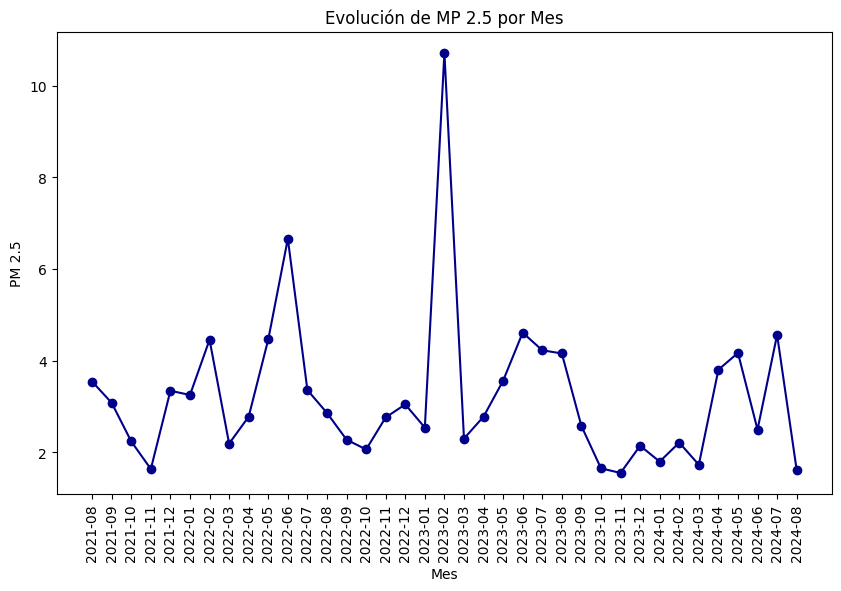

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que la columna 'date' sea tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Extraer el mes y el año de la columna 'date'
df['month'] = df['date'].dt.to_period('M')

# Agrupar por mes y calcular la media de 'pm_2_5'
df_monthly = df.groupby('month').mean().reset_index()

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_monthly['month'].astype(str), df_monthly['pm_2_5'], marker='o', linestyle='-', color='darkblue')

# Personalizar el gráfico
plt.title('Evolución de MP 2.5 por Mes')
plt.xlabel('Mes')
plt.ylabel('PM 2.5')
plt.grid(False)
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mejor visualización

# Mostrar el gráfico
plt.show()